In [98]:
%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.calibrator import Calibrator

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# create a tap list

Y = 8
X = 8
D = 3
N = X * Y
LAMBDA = 2

def to_idx(x, y):
    return y * X + x

if D == 1:
    tap_list = [
        [(to_idx(1, 1), 1), (to_idx(6, 3), -1)]]
elif D == 2:
    #tap_list = [
    #    [(to_idx(1, 1), 1), (to_idx(6, 3), -1)],
    #    [(to_idx(2, 5), 1), (to_idx(5, 2), -1)]]
    tap_list = [
        [(to_idx(1, 1), 1)],
        []]
elif D == 3:
    #tap_list = [
    #    [(to_idx(1, 1), 1), (to_idx(6, 3), -1)],
    #    [(to_idx(2, 5), 1), (to_idx(5, 2), -1)]]
    tap_list = [
        [],
        [(to_idx(1, 1), 1)],
        []]
dims = D

In [100]:
# generate approximate encoders

approx_encs = Calibrator.get_approx_encoders(tap_list, Y, X, LAMBDA)

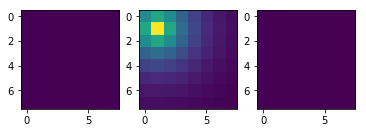

In [101]:
# plot the approximate encoders

yx_approx_encs = approx_encs.T.reshape((dims, Y, X))

if D == 1:
    plt.figure()
    plt.imshow(yx_approx_encs[0, :, :].T)
if D > 1:
    fig, ax = plt.subplots(1, D)
    for d in range(D):
        ax[d].imshow(yx_approx_encs[d, :, :].T)

# first two dims
if D == 2:
    plt.figure(figsize=(5,5))
    plt.scatter(approx_encs[:, 0], approx_encs[:, 1])

In [107]:
# get sample points
samples_per_enc = 1
ANGLES_AWAY = [np.pi / 4, np.pi / 8, np.pi / 16]

sample_pts = None
for angle in ANGLES_AWAY:
    new_sample_pts, thresh_encs = Calibrator.get_sample_points_around_encs(approx_encs, angle, samples_per_enc)
    if sample_pts is None:
        sample_pts = new_sample_pts
    else:
        sample_pts = np.vstack((sample_pts, new_sample_pts))
print(samples_per_enc)
print(sample_pts.shape)
print(thresh_encs)
print(sample_pts)

1
(15, 3)
[[0. 0. 0.]
 [0. 1. 0.]]
[[ 0.          1.          0.        ]
 [ 0.69215265  0.70710678  0.14465374]
 [-0.14465374  0.70710678  0.69215265]
 [-0.69215265  0.70710678 -0.14465374]
 [ 0.14465374  0.70710678 -0.69215265]
 [ 0.          1.          0.        ]
 [-0.87977845  0.38268343 -0.28203418]
 [ 0.28203418  0.38268343 -0.87977845]
 [ 0.87977845  0.38268343  0.28203418]
 [-0.28203418  0.38268343  0.87977845]
 [ 0.          1.          0.        ]
 [-0.57782522  0.19509032 -0.79250097]
 [-0.79250097  0.19509032  0.57782522]
 [ 0.57782522  0.19509032  0.79250097]
 [ 0.79250097  0.19509032 -0.57782522]]


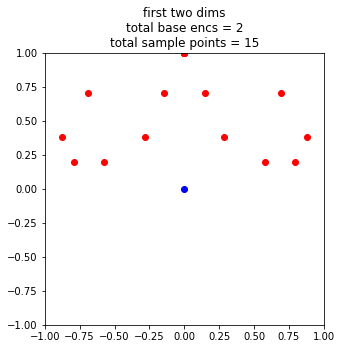

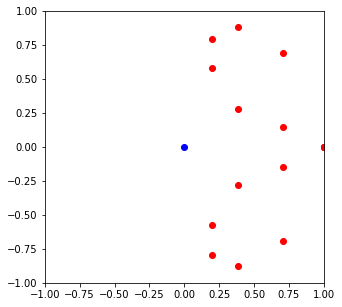

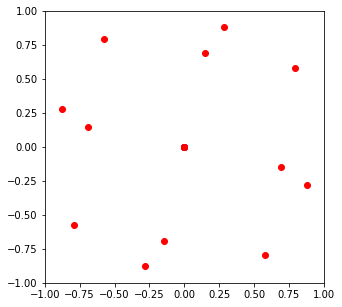

In [108]:
# plot resulting test points
if D >= 2:
    plt.figure(figsize=(5, 5))
    plt.axis([-1, 1, -1, 1])
    plt.scatter(thresh_encs[:, 0], thresh_encs[:, 1], c='b')
    plt.scatter(sample_pts[:, 0], sample_pts[:, 1], c='r')
    plt.title('first two dims' + 
              '\ntotal base encs = ' + str(thresh_encs.shape[0]) + 
              '\ntotal sample points = ' + str(sample_pts.shape[0]))
    
    plt.figure(figsize=(5, 5))
    plt.axis([-1, 1, -1, 1])
    plt.scatter(thresh_encs[:, 1], thresh_encs[:, 2], c='b')
    plt.scatter(sample_pts[:, 1], sample_pts[:, 2], c='r')
    
    plt.figure(figsize=(5, 5))
    plt.axis([-1, 1, -1, 1])
    plt.scatter(thresh_encs[:, 2], thresh_encs[:, 0], c='b')
    plt.scatter(sample_pts[:, 2], sample_pts[:, 0], c='r')
          

In [ ]:
# now rig up a fake neuron response generator to test this on
# first just do ideal responses, no noise

offset_scale = 20
offsets = (2 * np.random.rand(N,) - 1) * offset_scale
gain_scale = 100
gains = np.random.rand(N,) * gain_scale
noise_scale = 2

def nrn_fn(enc, offset, gain, x):
    return np.maximum(gain * np.dot(enc, x) + offset, 0)

firing_rates = np.zeros((sample_pts.shape[0], N))
for n in range(N):
    for s in range(sample_pts.shape[0]):
        firing_rates[s, n] = nrn_fn(approx_encs[n, :], offsets[n], gains[n], sample_pts[s, :])
        
firing_rates += np.maximum(0, np.random.randn(*firing_rates.shape) * noise_scale)


In [ ]:
# plot neurons' behaviors (just making sure I got the spike generation right)

if D == 1:
    plt.figure()
    for n in range(N):
        plt.scatter(sample_pts, firing_rates[:, n])
    
elif D == 2:
    
    # pick a neuron with a reasonable response
    nrn_idx = 0
    while True:
        if (np.abs(offsets[nrn_idx]) < .5 * offset_scale and 
            np.linalg.norm(approx_encs[nrn_idx, :]) > .2):
            break
        nrn_idx += 1
    #nrn_idx = np.random.randint(N)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(sample_pts[:, 0], sample_pts[:, 1], firing_rates[:, nrn_idx])
    
    plt.figure(figsize=(5, 5))
    plt.tricontourf(sample_pts[:, 0], sample_pts[:, 1], firing_rates[:, nrn_idx])
    plt.colorbar()

In [ ]:
# try fitting, compare estimates to actual encoders 

est_encs, est_offsets, residuals, insufficient = Calibrator.estimate_encs_from_tuning_curves(sample_pts, 
                                                                                             firing_rates, 
                                                                                             solver='scipy_opt',
                                                                                             fired_tolerance=5)

print(np.sum(insufficient), "/", est_encs.shape[0], "neurons needed more points")

In [ ]:
all_sample_pts = sample_pts.copy()
all_spikes = firing_rates.copy()
if D == 1:
    plot_nrn_idxs = np.random.randint(N, size=(10,))
    
    def make_plot():
        plt.figure()
        order = np.argsort(all_sample_pts.flatten())
        sorted_pts = all_sample_pts.flatten()[order]
        sorted_spikes = all_spikes[order, :]
        plt.gca().set_prop_cycle(None)
        plt.plot(sorted_pts, sorted_spikes[:, plot_nrn_idxs], '.-', alpha=.5)

        clean_encs = est_encs.copy()
        unest = np.isnan(est_offsets)
        clean_encs[unest, :] = 0
        clean_offsets = est_offsets.copy()
        clean_offsets[unest] = 0

        compare_pts = np.linspace(-1, 1, 100)
        est_A = np.maximum(0, np.dot(compare_pts.reshape(100, 1), clean_encs.T) + clean_offsets)
        plt.gca().set_prop_cycle(None)
        plt.plot(compare_pts, est_A[:, plot_nrn_idxs])
    
    make_plot()
    plt.axis([-1, 1, 0, 50])
    
    make_plot()
    plt.axis([-1, 1, 0, 20])

In [ ]:
# now try the same thing with the chip

%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.calibrator import Calibrator, PoolSpec

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [ ]:
# test the D > 1 create_default_yx_taps function (with no bad taps)
# this is in the SY, SX space, not Y,X space

np.random.seed(1)

Y = 8
X = 8
N = X * Y
D = 1
SYN_SPACE = 1
BIAS = -2

SY = Y // 2 // SYN_SPACE
SX = X // 2 // SYN_SPACE

yx_taps = NetBuilder.create_default_yx_taps(SY, SX, D, bad_syn=np.array([[False] * SY] * SX, dtype=bool))
print(yx_taps.shape)

if D == 1:
    plt.imshow(yx_taps[:, :, 0])
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        ax[d].imshow(yx_taps[:, :, d])

In [ ]:
# try again with bad_syn set to the first :SY, :SX taps from the chip data

from pystorm.hal import HAL
HAL = HAL()

net_builder = NetBuilder(HAL)
cal = Calibrator(HAL)

bad_syn, _ = cal.get_bad_syns()

yx_taps = NetBuilder.create_default_yx_taps(SY, SX, D, bad_syn=bad_syn[:SY, :SX])

plt.figure()
plt.imshow(bad_syn[:SY, :SX])

if D == 1:
    plt.figure()
    plt.imshow(yx_taps[:, :, 0])
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        ax[d].imshow(yx_taps[:, :, d])

In [ ]:
# now that we know that works, try the whole thing

tap_matrix = NetBuilder.syn_taps_to_nrn_taps(yx_taps, spacing=SYN_SPACE)
NetBuilder.make_taps_even(tap_matrix)

# create PoolSpec, which we'll use from now on with Calibrator
ps = PoolSpec(YX=(Y, X), loc_yx=(0, 0),
              TPM=tap_matrix,
              biases=BIAS)

net = net_builder.create_single_pool_net_from_spec(ps)
pool = net.get_pools()[0]
inp = net.get_inputs()[0]

# map the network
print("mapping network")
HAL.map(net)

FMAX = cal.optimize_fmax(ps)
ps.fmax = FMAX
print("using FMAX of", FMAX)

In [ ]:
# do it!
print("running encoders and offsets experiment")
est_encs, est_offsets, insufficient_samples, debug = cal.get_encoders_and_offsets(ps)

In [ ]:
all_sample_pts = debug['all_sample_pts']
all_spikes = debug['all_spikes']

def make_tuning_plot(all_sample_pts, all_spikes, est_encs, est_offsets, num_to_plot=None, seed=0):
    if num_to_plot is None:
        plot_nrn_idxs = np.arange(N)
    else:
        np.random.seed(seed)
        plot_nrn_idxs = np.random.randint(N, size=(num_to_plot,))

    plt.figure()
    order = np.argsort(all_sample_pts.flatten())
    sorted_pts = all_sample_pts.flatten()[order]
    sorted_spikes = all_spikes[order, :]
    plt.gca().set_prop_cycle(None)
    plt.plot(sorted_pts, sorted_spikes[:, plot_nrn_idxs], '.-', alpha=.5)

    clean_encs = est_encs.copy()
    unest = np.isnan(est_offsets)
    clean_encs[unest, :] = 0
    clean_offsets = est_offsets.copy()
    clean_offsets[unest] = 0

    compare_pts = np.linspace(-1, 1, 100)
    est_A = np.maximum(0, np.dot(compare_pts.reshape(100, 1), clean_encs.T) + clean_offsets)
    plt.gca().set_prop_cycle(None)
    plt.plot(compare_pts, est_A[:, plot_nrn_idxs])
    
if D == 1:
    
    def make_this_plot(num_to_plot=N, seed=0):
        make_tuning_plot(all_sample_pts, all_spikes, est_encs, est_offsets, num_to_plot, seed)
    
    make_this_plot()
    
    make_this_plot()
    plt.axis([-1, 1, 0, 100])
    
    seed = np.random.randint(100)
    make_this_plot(num_to_plot=N//4, seed=seed)
    
    make_this_plot(num_to_plot=N//4, seed=seed)
    plt.axis([-1, 1, 0, 100])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

if D == 1:
    plt.figure()
    plt.imshow(est_encs.reshape(Y, X))
    plt.colorbar()
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        im = ax[d].imshow(est_encs[:, d].reshape(Y, X))
        divider = make_axes_locatable(ax[d])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
plt.figure()
plt.hist(est_offsets[~np.isnan(est_offsets)], bins=20)

gain = np.linalg.norm(est_encs, axis=1)
bias = est_offsets

plt.figure()
plt.scatter(gain, bias)
x = np.linspace(0, max(gain), 100)
plt.plot(x, x)
plt.plot(x, -x)

unit_encs = (est_encs.T / gain).T

if D > 1:
    plt.figure()
    plt.scatter(unit_encs[:, 0], unit_encs[:, 1])



In [ ]:
# validate estimated encoders and offsets

NUM_VAL_SAMPLES = 20
if D == 1:
    val_pts = np.linspace(-1, 1, NUM_VAL_SAMPLES).reshape((NUM_VAL_SAMPLES, 1))
else:
    val_pts = np.random.randn(NUM_VAL_SAMPLES, D)
    val_pts_norms = np.linalg.norm(val_pts, axis=1)
    val_pts = (val_pts.T / val_pts_norms).T

rmse, meas_A, est_A = cal.validate_est_encs(est_encs, est_offsets, ps, val_pts)

In [ ]:
clean_encs = est_encs.copy()
unest = np.isnan(est_offsets)
clean_encs[unest, :] = 0
clean_offsets = est_offsets.copy()
clean_offsets[unest] = 0

est_A = np.maximum(0, np.dot(val_pts, clean_encs.T) + clean_offsets)

RMSE = np.sqrt(np.mean((est_A.flatten() - meas_A.flatten())**2))

plt.figure()
plt.imshow(est_A)
plt.colorbar()
plt.title('est_A')

plt.figure()
plt.imshow(meas_A)
plt.colorbar()
plt.title('meas_A')

plt.figure()
plt.imshow(meas_A - est_A)
plt.colorbar()
plt.title('diff')


if D == 1:
    plt.figure()
    plt.gca().set_prop_cycle(None)
    plt.plot(val_pts, meas_A, '.-')
    plt.gca().set_prop_cycle(None)
    plt.plot(val_pts, est_A, '-')
    
    plt.figure()
    plt.gca().set_prop_cycle(None)
    plt.plot(val_pts, meas_A, '.-')
    plt.gca().set_prop_cycle(None)
    plt.plot(val_pts, est_A, '-')
    plt.axis([-1, 1, 0, 200])
    
    #nrn_cmap = plt.get_cmap("viridis")(np.linspace(0, 1, meas_A.shape[1]))
    #color_idxs = np.argsort(clean_offsets)
    #nrn_colors = nrn_cmap[color_idxs]
    #
    #plt.figure()
    #for n in range(meas_A.shape[1]):
    #    plt.plot(val_pts, meas_A[:, n], '.-', c=nrn_colors[n])
    #for n in range(meas_A.shape[1]):
    #    plt.plot(val_pts, est_A[:, n], '-', c=nrn_colors[n])
    #
    #plt.figure()
    #for n in range(meas_A.shape[1]):
    #    plt.plot(val_pts, meas_A[:, n], '.-', c=nrn_colors[n])
    #for n in range(meas_A.shape[1]):
    #    plt.plot(val_pts, est_A[:, n], '-', c=nrn_colors[n])
    #plt.axis([-1, 1, 0, 200])
    
    #valid_off = ~np.isnan(est_offsets)
    #low_off = est_offsets < np.median(est_offsets[valid_off])
    #meas_A_low = meas_A[:, low_off & valid_off]
    #est_A_low = est_A[:, low_off & valid_off]
    #
    #plt.figure()
    #plt.plot(meas_A_low, 'b')
    #plt.plot(est_A_low, 'r')
